In [1]:
include("MyLinInterp.jl")

MyLinInterp

In [3]:
println("これを用いてlogを線形補間してみる")
cgrid = linspace(1, 10, 5)
cvals = log(cgrid)
println("cgridとして[1, 10]を5分割した配列をとり, logを適用した値をcvalに格納")

a = MyLinInterp.LinearInterpolation(cgrid, cvals)
println("この線形補間された関数とlogをplotしてみる")

これを用いてlogを線形補間してみる
cgridとして[1, 10]を5分割した配列をとり, logを適用した値をcvalに格納
この線形補間された関数とlogをplotしてみる


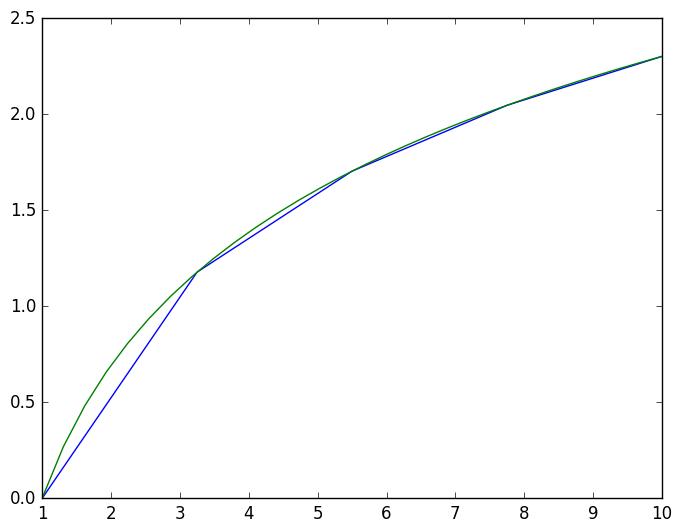

In [4]:
using PyPlot

plot(cgrid, cvals)
fgrid = linspace(1, 10, 30)
plot(fgrid, log(fgrid))
legend()

In [11]:
println("同様にsinを線形補間してみる")
cgrid = linspace(-5pi, 5pi, 30)
cvals = sin(cgrid)
println("cgridとして[-5π,  5π]を30分割した配列をとり, sinを適用した値をcvalに格納")

b = MyLinInterp.LinearInterpolation(cgrid, cvals)
println("この線形補間された関数とsinをplotしてみる")

同様にsinを線形補間してみる
cgridとして[-5π,  5π]を30分割した配列をとり, sinを適用した値をcvalに格納
この線形補間された関数とsinをplotしてみる


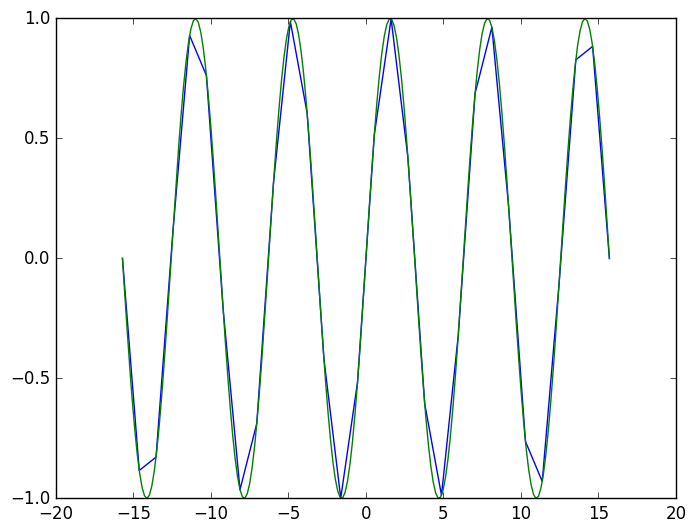

In [13]:
plot(cgrid, cvals)
fgrid = linspace(-5pi, 5pi, 200)
plot(fgrid, sin(fgrid))
legend()